# Semester 1 Project Submission

Please fill out:
* Student name: Cristian González Ramírez
* Instructor name: Nick McCarty & Julian Ward

# This notebook tries to answer to the following question:

*How are the production budgets for movies based on their genre in comparison to their income? Would it be profitable?*

For this question specifically, we are interested on knowing the Production Costs, the Total Gross (both domestic and foreign) and the genres. We find this info in the following dataframes and tables:
* `movie_budgets`
* `SQL im.db"`

## Retreiving and cleaning data up

### Importing libraries
We will start by adding the basic libraries to our notebook, so it runs nice and smoothly.

In [577]:
# Import all libraries the project will requiere

#For retreiving data
import pandas as pd
import sqlite3
import zipfile

#For analyzing data
from scipy import stats

#For plotting and visulaizations
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Retreiving general information
Then, we insert the data we will be working with.

In [578]:
#Retrieving data to work with
#movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
#movies           = pd.read_csv("zippedData/tmdb.movies.csv.gz")
movie_budgets    = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

#movie_info_data  = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep="\t")

In [579]:
#Oppening SQLite3 zip
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

conn = sqlite3.connect("im.db")
cur = conn.cursor()

### Cleaning Movie Budgets data

Before starting any anylisis at all, we have to be sure that the data we are dealing with is ready to be manipulated. In order to accopmlish it, we musgt clean the data from all the tables we are using. First we will start with `movie_budget`

In [580]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [581]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


As we see all of the values are a `Not-Null`, so most of the job is done; even so, a few considerations must be taken.

Here we check if there is any movie appearing more than once.

In [582]:
print(len(movie_budgets.movie.unique()), movie_budgets.shape[0])

5698 5782


Since these two numbers differ, we must take a look into it and remove any duplicates if any.

In [583]:
movie_budgets.movie.value_counts()

King Kong            3
Halloween            3
Home                 3
Friday the 13th      2
Heist                2
                    ..
The Equalizer 2      1
Romeo Is Bleeding    1
Playing for Keeps    1
Trolls               1
Jackie               1
Name: movie, Length: 5698, dtype: int64

In fact, we have a bunch of repeating movies. We have to deal with them, so they only appear once.

In [584]:
movie_budgets.drop_duplicates(subset=["movie"], inplace = True)

In [585]:
print(len(movie_budgets.movie.unique()), movie_budgets.shape[0])

5698 5698


Now both values are similiar, which let us know that we got rid of duplicates perfectly.

Runnig the `.info()` command above, we also have found that `production_budget`, `domestic_gross` and `worldwide_gross` are object types, when we need them to be a numeric value, to perform further comparisons. So we have to take care of that issue too.

In [586]:
#Getting rid off commas so it can be casted
movie_budgets.production_budget.replace(",","",regex=True, inplace=True)
movie_budgets.domestic_gross.replace(",","",regex=True, inplace=True)
movie_budgets.worldwide_gross.replace(",","",regex=True, inplace=True)

#Getting rid off $
movie_budgets["production_budget"] = movie_budgets.production_budget.str.strip("$")
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.str.strip("$")
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.str.strip("$")

In [587]:
#Casting foreign_gross as a float
movie_budgets["production_budget"] = movie_budgets.production_budget.astype(float)
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.astype(float)
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.astype(float)

In [588]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


It could be useful to have a `total_gross` and `profit_or_loss` column for easier analysis later.

In [589]:
movie_budgets["total_gross"] = movie_budgets.domestic_gross + movie_budgets.worldwide_gross
movie_budgets["profit_or_loss"] = movie_budgets.total_gross - movie_budgets.production_budget

In [590]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,profit_or_loss
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,3.536853e+09,3.111853e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.286728e+09,8.761278e+08
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-1.574753e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.862020e+09,1.531420e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,1.936903e+09,1.619903e+09


### Retreiving Movie Ratings data
Now we get the info from the relevant SQL table for the analysis.

In [591]:
#Obtain relevant information from SQL database
query = '''
    SELECT
        movie_id AS "ID",
        primary_title AS "Title",
        original_title AS "Original Title",
        genres AS "Genres",
        averagerating AS "Rating",
        numvotes AS "Number of Votes"
    FROM movie_basics
        JOIN movie_ratings
        USING (movie_id)
'''

#Assign the query to a pandas dataframe
movie_rating = pd.read_sql(query,conn)

In [592]:
movie_rating.head(10)

,ID,Title,Original Title,Genres,Rating,Number of Votes
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy",6.5,119
5,tt0112502,Bigfoot,Bigfoot,"Horror,Thriller",4.1,32
6,tt0137204,Joe Finds Grace,Joe Finds Grace,"Adventure,Animation,Comedy",8.1,263
7,tt0146592,Pál Adrienn,Pál Adrienn,Drama,6.8,451
8,tt0154039,So Much for Justice!,Oda az igazság,History,4.6,64
9,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,Documentary,7.6,53


### Cleaning SQL data

In [593]:
movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               73856 non-null  object 
 1   Title            73856 non-null  object 
 2   Original Title   73856 non-null  object 
 3   Genres           73052 non-null  object 
 4   Rating           73856 non-null  float64
 5   Number of Votes  73856 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 3.4+ MB


As we can see, most of the data we obtain is complete, but there may still be some values that could mess up our analysis, so we better clean this data as well!

In [594]:
print(len(movie_rating.Title.unique()), movie_rating.shape[0])

69993 73856


In [595]:
movie_rating.Title.value_counts()

The Return              11
Broken                  10
Together                 9
Lucky                    9
Homecoming               9
                        ..
Peculiar Pets            1
Pour l'amour de Dieu     1
After Party              1
Red Cow                  1
Shilo                    1
Name: Title, Length: 69993, dtype: int64

In [596]:
movie_rating.drop_duplicates(subset=["Title"], inplace=True)

In [597]:
print(len(movie_rating.Title.unique()), movie_rating.shape[0])

69993 69993


In [598]:
print(len(movie_rating["Original Title"].unique()), movie_rating["Original Title"].shape[0])

69820 69993


In [599]:
movie_rating["Original Title"].value_counts()

Missed Connections          3
Mundo Cão                   2
Iris                        2
Ra                          2
Snatched                    2
                           ..
Auf den zweiten Blick       1
Angelus Hiroshimae          1
Molly's Girl                1
The Melancholy Fantastic    1
Shilo                       1
Name: Original Title, Length: 69820, dtype: int64

In [600]:
movie_rating.drop_duplicates(subset=["Original Title"], inplace = True)

In [601]:
print(len(movie_rating["Original Title"].unique()), movie_rating["Original Title"].shape[0])

69820 69820


In [602]:
movie_rating.Rating.unique()

array([ 7. ,  7.2,  6.9,  6.1,  6.5,  4.1,  8.1,  6.8,  4.6,  7.6,  7.5,
        7.8,  4. ,  8.8,  1.9,  6.7,  6.6,  5.9,  7.1,  7.4,  3.9,  5.5,
        5.1,  7.9,  6.2,  6.3,  5. ,  6. ,  5.6,  7.3,  4.9,  6.4,  3.3,
        5.7,  8.6,  4.8,  4.5,  4.2,  8.7,  4.7,  5.2,  8.3,  9.1,  3.4,
        5.8,  5.4,  8.5,  3.2,  3.6,  8. ,  3.8,  7.7,  4.3,  3. ,  5.3,
        3.7,  3.5,  9.3,  8.9,  9. ,  2.3,  8.2,  2.7,  2.8,  1.7,  4.4,
        2.2,  9.4,  8.4,  9.2,  9.7,  3.1, 10. ,  9.8,  2.6,  2.5,  1.4,
        2.1,  2.4,  2.9,  1.8,  1.6,  2. ,  1. ,  1.2,  1.5,  1.3,  1.1,
        9.5,  9.6,  9.9])

We can see there is no apparent problem in the Rating column

In [603]:
movie_rating.ID.value_counts().sort_values(ascending = True)

tt8428316    1
tt2354215    1
tt7054868    1
tt1334455    1
tt7397958    1
            ..
tt1795046    1
tt6096958    1
tt6202264    1
tt8998610    1
tt1619814    1
Name: ID, Length: 69820, dtype: int64

Nor there is any in the ID column. 

Most of the cleaning of this Dataframe is done. The next step to do is to decide how to procede with the missing values we saw in the Genres column. There are around 800 missing values, and dropping those columns won't represent as much of a loss, so we will proceed with this approach.

In [604]:
movie_rating = movie_rating[movie_rating.Genres.str.contains("None") == False]

In [605]:
movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69059 entries, 0 to 73852
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               69059 non-null  object 
 1   Title            69059 non-null  object 
 2   Original Title   69059 non-null  object 
 3   Genres           69059 non-null  object 
 4   Rating           69059 non-null  float64
 5   Number of Votes  69059 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 3.7+ MB


We can see we have a dataframe without any null value or duplicates. We can consider this dataframe to be clean!

Nevertheless, before moving forward, I will consider an extra step for singificance in later analysis; which is getting the percentage of rating base on the number of votes. Where we will use the greatest `Number of votes` as reference to all the movies, i.e. the movie with its `Number of voters` value equal to `max_voters` will have a significance of `1`.

In [606]:
max_voters = movie_rating["Number of Votes"].max()
movie_rating["Significance"] = (movie_rating["Number of Votes"]/max_voters)

In [607]:
movie_rating.head()

,ID,Title,Original Title,Genres,Rating,Number of Votes,Significance
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama",7.0,77,0.000042
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama",7.2,43,0.000023
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama,6.9,4517,0.002453
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama",6.1,13,0.000007
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy",6.5,119,0.000065


In [608]:
movie_rating.loc[(movie_rating["Number of Votes"]) == max_voters]

,ID,Title,Original Title,Genres,Rating,Number of Votes,Significance
2387,tt1375666,Inception,Inception,"Action,Adventure,Sci-Fi",8.8,1841066,1.0


### Merging tables
Now, we shall proceed with joining the `movie_rating` table with the `movie_budgets` one to proceed with the analysis.

In [609]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,profit_or_loss
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,3.536853e+09,3.111853e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.286728e+09,8.761278e+08
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-1.574753e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.862020e+09,1.531420e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,1.936903e+09,1.619903e+09


In [610]:
#Create a new Dataframe
gross_and_rating = pd.merge(movie_budgets, movie_rating, how="inner", left_on="movie", right_on="Title")

In [611]:
gross_and_rating.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,profit_or_loss,ID,Title,Original Title,Genres,Rating,Number of Votes,Significance
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,3.536853e+09,3.111853e+09,tt1775309,Avatar,Abatâ,Horror,6.1,43,0.000023
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.286728e+09,8.761278e+08,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,447624,0.243133
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-1.574753e+08,tt6565702,Dark Phoenix,Dark Phoenix,"Action,Adventure,Sci-Fi",6.0,24451,0.013281
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.862020e+09,1.531420e+09,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",7.3,665594,0.361526
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2.726950e+09,2.426950e+09,tt4154756,Avengers: Infinity War,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.5,670926,0.364423


In [612]:
#Deleting duplicated columns

del gross_and_rating["Title"]
del gross_and_rating["Original Title"]
del gross_and_rating["id"]

In [613]:
gross_and_rating.columns

Index(['release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'total_gross', 'profit_or_loss', 'ID', 'Genres',
       'Rating', 'Number of Votes', 'Significance'],
      dtype='object')

In [614]:
gross_and_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 0 to 2110
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       2111 non-null   object 
 1   movie              2111 non-null   object 
 2   production_budget  2111 non-null   float64
 3   domestic_gross     2111 non-null   float64
 4   worldwide_gross    2111 non-null   float64
 5   total_gross        2111 non-null   float64
 6   profit_or_loss     2111 non-null   float64
 7   ID                 2111 non-null   object 
 8   Genres             2111 non-null   object 
 9   Rating             2111 non-null   float64
 10  Number of Votes    2111 non-null   int64  
 11  Significance       2111 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 214.4+ KB


In [615]:
gross_and_rating.movie.value_counts()

Sin City: A Dame to Kill For                     1
Trolls                                           1
Legend of the Guardians: The Owls of Ga'Hoole    1
Red Tails                                        1
Sausage Party                                    1
                                                ..
Julia                                            1
The Revenant                                     1
The Place Beyond the Pines                       1
Trespass                                         1
Jackie                                           1
Name: movie, Length: 2111, dtype: int64

Finally, after getting all of our interest values together, the next step would be to jump into analysis, in which we compare the income of a movie based on its genre with the production budget it had.

## Performing analysis

Let us recall the question we are trying to solve:

*"How are the production budgets for movies based on their genre in comparison to their income? Would it be profitable?"*

Therefore, we have to compare each movie with each genre, but as we can see, many of them have multiple genres, which may represent a problem while comparing them, but we cannot leave genres out of the analysis. The bes suitable option I can think of, is to separate the movie into its respective genres and have it multiple time.

We will fix the duplicates later.

In [616]:
gross_and_rating.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,profit_or_loss,ID,Genres,Rating,Number of Votes,Significance
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,3.536853e+09,3.111853e+09,tt1775309,Horror,6.1,43,0.000023
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.286728e+09,8.761278e+08,tt1298650,"Action,Adventure,Fantasy",6.6,447624,0.243133
2,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.925247e+08,-1.574753e+08,tt6565702,"Action,Adventure,Sci-Fi",6.0,24451,0.013281
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.862020e+09,1.531420e+09,tt2395427,"Action,Adventure,Sci-Fi",7.3,665594,0.361526
4,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2.726950e+09,2.426950e+09,tt4154756,"Action,Adventure,Sci-Fi",8.5,670926,0.364423


In [626]:
#Grouping movies by genre
genre_gross = gross_and_rating.groupby(by="Genres", as_index=False).sum()

In [651]:
#Getting data from most profitable to less profitable
genre_gross_top = genre_gross.sort_values(by="profit_or_loss", ascending=False).head(50)
genre_gross_bottom = genre_gross.sort_values(by="profit_or_loss").head(50)

In [652]:
genre_gross_top.head()

,Genres,production_budget,domestic_gross,worldwide_gross,total_gross,profit_or_loss,Rating,Number of Votes,Significance
12,"Action,Adventure,Sci-Fi",9.070400e+09,1.258900e+10,3.429490e+10,4.688390e+10,3.781350e+10,366.3,21655918,11.762706
70,"Adventure,Animation,Comedy",6.671500e+09,8.782345e+09,2.492866e+10,3.371101e+10,2.703951e+10,429.6,6865722,3.729210
8,"Action,Adventure,Fantasy",4.935600e+09,4.149066e+09,1.306933e+10,1.721840e+10,1.228280e+10,210.3,7739372,4.203745
4,"Action,Adventure,Comedy",2.351500e+09,3.323180e+09,9.215448e+09,1.253863e+10,1.018713e+10,179.0,5909923,3.210055
2,"Action,Adventure,Animation",1.957500e+09,2.664329e+09,7.435879e+09,1.010021e+10,8.142708e+09,126.3,3063175,1.663805


In [653]:
genre_gross_bottom.head()

,Genres,production_budget,domestic_gross,worldwide_gross,total_gross,profit_or_loss,Rating,Number of Votes,Significance
32,"Action,Crime,Fantasy",90000000.0,0.0,0.0,0.0,-90000000.0,6.4,147834,0.080298
51,"Action,Family,Fantasy",90000000.0,195459.0,20466016.0,20661475.0,-69338525.0,4.3,3119,0.001694
183,"Comedy,Western",66000000.0,5909483.0,8446952.0,14356435.0,-51643565.0,10.3,57864,0.031430
190,"Crime,Drama,History",92000000.0,12958326.0,27829311.0,40787637.0,-51212363.0,19.9,105312,0.057202
120,"Biography,Crime,Documentary",87000000.0,18115927.0,19819208.0,37935135.0,-49064865.0,14.2,67,0.000036


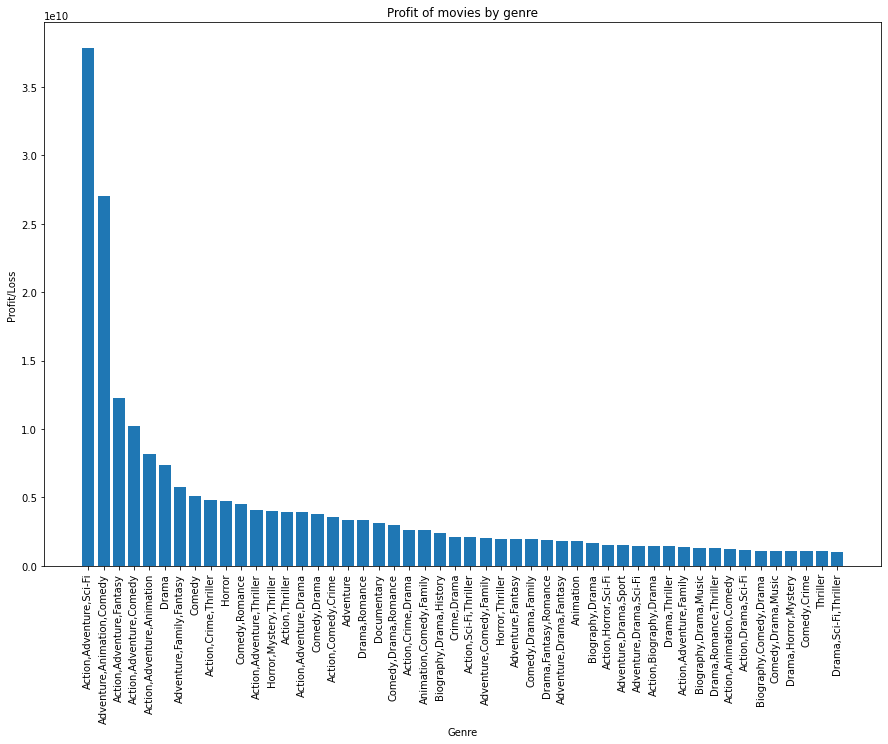

In [662]:
fig, ax= plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)

plt.bar(genre_gross_top.Genres,genre_gross_top.profit_or_loss)
plt.title("Profit of movies by genre")
plt.xlabel("Genre")
plt.ylabel("Profit/Loss")
plt.show()